# MLSP 2014 Schizophrenia Classification Challenge

source: https://www.kaggle.com/c/mlsp-2014-mri/data

![title](https://upload.wikimedia.org/wikipedia/commons/thumb/4/45/100325_RS88UH_11_qc.gif/330px-100325_RS88UH_11_qc.gif)

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedShuffleSplit, KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_recall_curve, accuracy_score, precision_score, recall_score
from sklearn.metrics import auc, confusion_matrix
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
import time
import sys
import os

# ignore warnings
import warnings
warnings.filterwarnings('ignore');

# display multiple outputs within a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";

**Overview & fMRI features**:<br>
- 86 total patients labeled 0 (healthy) or 1 (patient has schizophrenia) <br>
- Each individual has 379 Functional Network Connectivity (FNC) features, which are correlation values between each pairing of the total 28 brain regions/maps of interest (ROI) <br>
- We consider the 28 brain regions as nodes in a subject's connectivity graph, and we insert edge(region A, region B) if the corresponding FNC (correlation) is greater than some threshhold <br>
- Each of the subjects has a unique network connectivity graph which we analyze in order to detect the presence of schizophrenia

In [23]:
train_data = pd.read_csv('train/train_fnc.csv')
train_data.head()
train_data.shape
train_labels = pd.read_csv('train/train_labels.csv')
train_labels.shape
map_functional = pd.read_csv('add_info/comp_ind_fmri.csv', index_col=None)
map_functional.head()
map_functional.shape

,Id,FNC1,FNC2,FNC3,FNC4,FNC5,FNC6,FNC7,FNC8,FNC9,...,FNC369,FNC370,FNC371,FNC372,FNC373,FNC374,FNC375,FNC376,FNC377,FNC378
0,120873,0.34312,0.045761,-0.13112,0.15034,0.18082,0.289160,0.069545,-0.052489,0.124000,...,0.18743,0.163770,0.17686,0.074728,0.148600,0.343230,0.17565,0.52035,0.030613,0.30774
1,135376,0.28790,0.102570,-0.32343,-0.22776,0.12328,0.367020,-0.084040,0.038793,-0.006287,...,0.59834,-0.477880,0.26634,0.582940,-0.041272,0.630050,0.70314,0.36383,-0.207880,0.64138
2,139149,0.24585,0.216620,-0.12468,-0.35380,0.16150,-0.002032,-0.133020,-0.035222,0.259040,...,0.22866,-0.000816,0.25860,0.280450,-0.644640,0.332440,0.87074,-0.10973,-0.679160,0.32316
3,146791,0.42090,0.331380,0.24453,0.17167,0.59223,0.431050,0.280290,0.289620,0.356800,...,0.42881,0.711570,0.56593,0.248560,0.153860,0.093171,0.62556,0.60391,-0.058301,0.10779
4,153870,-0.14621,-0.468630,-0.52880,-0.50381,-0.51052,-0.029113,-0.015192,0.360170,0.005944,...,0.41688,-0.435600,0.32104,0.392960,-0.842430,0.425080,0.86509,-0.31281,-0.829640,0.24307


(86, 379)

(86, 2)

,fMRI_comp_ind
0,7
1,17
2,20
3,21
4,23


(28, 1)

In [24]:
map_functional = map_functional['fMRI_comp_ind'].to_dict()
map_functional_r = {v: k for k, v in map_functional.items()}
mapping = pd.read_csv('add_info/rs_fmri_fnc_mapping.csv')
mapping.head()
mapping.shape

,FNC,mapA,mapB
0,1,21,17
1,2,21,7
2,3,21,23
3,4,21,24
4,5,21,38


(378, 3)

In [26]:
N_NODES = 28
CORR_THRESH = 0.1
N_GRAPHS = 86
def create_connectome(data, graph_id, mapping):
    u = np.zeros((N_NODES, N_NODES))
    n_edges = mapping.shape[0]
    for i in range(n_edges):
        e0, e1 = (mapping.iloc[i]['mapA'], mapping.iloc[i]['mapB'])
        region0, region1 = map_functional_r[e0], map_functional_r[e1]
        u[region0, region1] = data.iloc[graph_id][i]
        u = np.multiply(u, (u > CORR_THRESH))
    return np.abs(u + u.T)
create_connectome(train_data, 0, mapping).shape

graph_data = [None] * N_GRAPHS
graph_labels = np.zeros(N_GRAPHS)
for graph_id in range(N_GRAPHS):
    graph_data[graph_id] = create_connectome(train_data, graph_id, mapping)
    graph_labels[graph_id] = int(train_labels.loc[train_data.index[graph_id], 'Class'])

(28, 28)

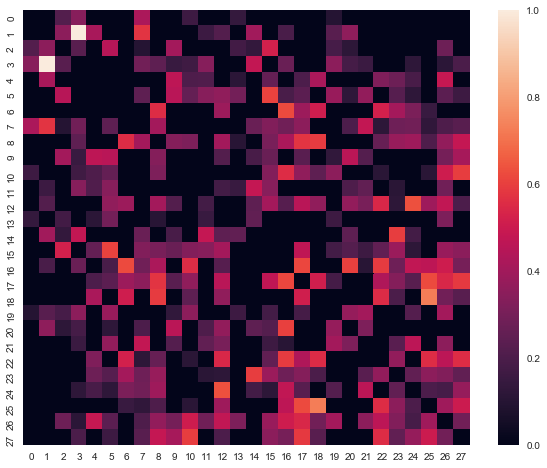

In [15]:
plt.figure(figsize=((10, 8)))
sns.heatmap(graph_data[0], vmin=0, vmax=1);